In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats

import util as u

from sklearn.model_selection import train_test_split

/Users/kendra/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [ ]:
churn_df = pd.read_csv('Data/train_v2.csv')
trans_df = pd.read_csv('Data/transactions_v2.csv')

In [32]:
logs_df = pd.read_csv('Data/user_logs_v2.csv')

In [2]:
member_df = pd.read_csv('Data/members_v3.csv')

### Create 'user' dataframe

In [3]:
churn_df.head()

,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


In [4]:
member_df.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915


In [156]:
# merge churn & member df's:
user_df = pd.merge(churn_df, member_df, on='msno', how='left')

In [6]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970960 entries, 0 to 970959
Data columns (total 7 columns):
msno                      970960 non-null object
is_churn                  970960 non-null int64
city                      860967 non-null float64
bd                        860967 non-null float64
gender                    388905 non-null object
registered_via            860967 non-null float64
registration_init_time    860967 non-null float64
dtypes: float64(4), int64(1), object(2)
memory usage: 59.3+ MB


**city**

In [7]:
user_df['city'].unique()

array([ 5., 13.,  1., 22.,  9., 12.,  6., 14.,  4., nan, 15., 18.,  3.,
       21.,  8.,  7., 17., 11., 10., 20., 16., 19.])

a lot of levels, and probably not that informative. Do not include

**bd = age**

In [8]:
user_df['bd'].describe()

count    860967.000000
mean         13.583854
std          20.064040
min       -3152.000000
25%           0.000000
50%           0.000000
75%          27.000000
max        2016.000000
Name: bd, dtype: float64

Some anomalously high (age=2016?) and negative values...

/Users/kendra/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


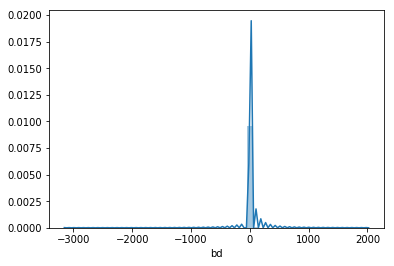

In [9]:
sns.distplot(user_df['bd'].dropna())

In [10]:
user_df['bd'].value_counts(1).head()

0.0     0.550229
27.0    0.026466
26.0    0.025354
25.0    0.023986
24.0    0.023573
Name: bd, dtype: float64

...and 55% of age entries are 0 -- this will not be a very useful feature. Drop it

**gender**: A lot of missing/null entries. Do not include

**registered_via**: small # of levels. Few # of nulls (see above). Include as categorical (even though it's unclear what these correspond to)

In [14]:
user_df['registered_via'].unique()

array([ 3.,  7.,  9., nan,  4., 13.])

In [157]:
user_df.drop(columns=['gender', 'city', 'bd'], inplace=True)
user_df['registration_init_time'] = pd.to_datetime(user_df['registration_init_time'], format='%Y%m%d')

### Logs

In [33]:
logs_df.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


1. Summarize song data

In [34]:
# logs: summarize data
logs_df['num_songs'] = (logs_df['num_25'] + logs_df['num_50'] + logs_df['num_75'] 
                        + logs_df['num_985'] + logs_df['num_100'])
logs_df['full_pct'] = logs_df['num_100']) / logs_df['num_songs']
logs_df['short_pct'] = logs_df['num_25'] / logs_df['num_songs']

Check distributions

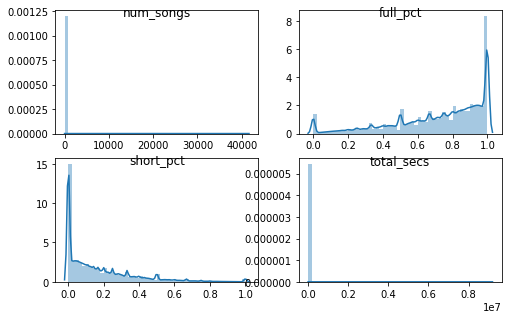

In [35]:
cols_to_plot = ['num_songs', 'full_pct', 'short_pct', 'total_secs']
fig, ax = plt.subplots(2,2, figsize=(8,5))
i = 1
for col in cols_to_plot:
    plt.subplot(2,2,i)
    sns.distplot(logs_df[col].values)
    plt.title(col, y=0.9)
    i += 1

num_songs & total_secs look odd. Investigate:

There can't be more than 86,400 seconds in a day

In [36]:
sec_in_day = 24*60*60
sec_in_day

86400

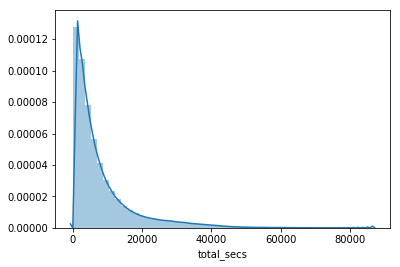

In [37]:
test = logs_df[logs_df['total_secs'] < sec_in_day]
sns.distplot(test['total_secs'])

Dropping entries whose total_seconds was greater than the length of one day makes the distribution look more reasonable.

In [38]:
# Drop any entries whose total_seconds are greater than the # of seconds in a day
logs_df = logs_df[logs_df['total_secs'] < sec_in_day]

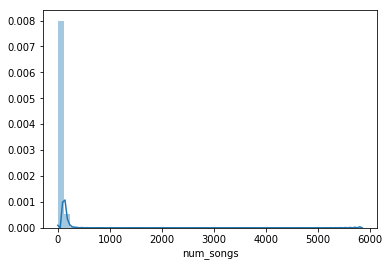

In [39]:
sns.distplot(test['num_songs'])

num_songs still has a long tail, though max is reduced from 40,000 to 6,000. Investigate a bit further?

In [41]:
test = logs_df[(logs_df['num_songs'] > 100)]
test.sort_values(by='num_songs', ascending=False, inplace=True)
test.head(10)

/Users/kendra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,num_songs,full_pct,short_pct
17059972,7BZG2lfVLlxqRCObINP+5Df/4qT6JPkWDjCt5DpgYZw=,20170304,5639,2,1,0,202,38,54517.972,5844,0.034565,0.964921
8222868,9l99IEY5/QEr8WQPTCdLgJ+KEWgBhzqh07D35B9Ovpo=,20170319,5213,92,43,35,74,4925,56495.594,5457,0.013561,0.955287
7046095,BwsZl/usCkpcT++8DjpwFOY7WkicBtYBGo6ggB9cPY4=,20170328,4357,57,17,13,15,103,30922.388,4459,0.003364,0.977125
4648064,BwsZl/usCkpcT++8DjpwFOY7WkicBtYBGo6ggB9cPY4=,20170326,4312,51,16,7,12,92,29334.643,4398,0.002729,0.980446
14349285,BwsZl/usCkpcT++8DjpwFOY7WkicBtYBGo6ggB9cPY4=,20170327,4155,53,14,7,16,97,27183.580,4245,0.003769,0.978799
8519816,BwsZl/usCkpcT++8DjpwFOY7WkicBtYBGo6ggB9cPY4=,20170329,3991,23,10,9,9,98,21137.749,4042,0.002227,0.987382
2198395,9l99IEY5/QEr8WQPTCdLgJ+KEWgBhzqh07D35B9Ovpo=,20170317,3799,51,16,5,12,3547,26393.951,3883,0.003090,0.978367
18240058,9l99IEY5/QEr8WQPTCdLgJ+KEWgBhzqh07D35B9Ovpo=,20170321,3644,51,40,21,68,3016,42199.007,3824,0.017782,0.952929
15508580,BwsZl/usCkpcT++8DjpwFOY7WkicBtYBGo6ggB9cPY4=,20170323,3456,40,12,5,9,85,19409.655,3522,0.002555,0.981261
12389880,9l99IEY5/QEr8WQPTCdLgJ+KEWgBhzqh07D35B9Ovpo=,20170318,3349,66,27,15,52,3237,34725.232,3509,0.014819,0.954403


In [42]:
test['num_songs'].describe()

count    1.693897e+06
mean     1.502464e+02
std      5.575340e+01
min      1.010000e+02
25%      1.150000e+02
50%      1.350000e+02
75%      1.660000e+02
max      5.844000e+03
Name: num_songs, dtype: float64

I think this is reasonable -- some people just burn through a lot of songs in one day. Don't drop any further entries based on num_songs, for now.

In [43]:
logs_df.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,num_songs,full_pct,short_pct
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273,34,0.617647,0.235294
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699,14,0.642857,0.142857
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337,147,0.571429,0.353741
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454,203,0.093596,0.866995
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558,116,0.965517,0.017241


#### Grouping

In [153]:
log_grp_df = logs_df.groupby('msno').aggregate({'num_25':'mean', 'num_50':'mean','num_75':'mean',
                                                'num_985':'mean','num_100':'mean','num_unq':'mean',
                                                'num_songs':['mean','sum'], 'total_secs':['mean','sum','count'],
                                                'full_pct':'mean', 'short_pct':'mean'})

In [48]:
def fix_col_names(s):
    if type(s) == tuple:
        s = '_'.join(s)
    return s

In [154]:
log_grp_df.columns = [fix_col_names(col) for col in log_grp_df.columns]

In [158]:
# merge with user_df & fix column names
user_df = pd.merge(user_df, log_grp_df, how='left', on='msno')
user_df.rename(columns={'total_secs_count':'num_log_entries'}, inplace=True)

Interesting that not all users appear in logs.

In [53]:
test = user_df[user_df['num_songs_mean'].isna()]
test['is_churn'].value_counts(1)

0    0.909019
1    0.090981
Name: is_churn, dtype: float64

In [54]:
user_df['is_churn'].value_counts(1)

0    0.910058
1    0.089942
Name: is_churn, dtype: float64

User being absent from log does not appear to be correlated to churn

## Transactions

In [25]:
trans_df.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,298,298,0,20170131,20170504,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150809,20190412,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,20170303,20170422,0
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,20170329,20170331,1
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,20170323,20170423,0


In [26]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431009 entries, 0 to 1431008
Data columns (total 9 columns):
msno                      1431009 non-null object
payment_method_id         1431009 non-null int64
payment_plan_days         1431009 non-null int64
plan_list_price           1431009 non-null int64
actual_amount_paid        1431009 non-null int64
is_auto_renew             1431009 non-null int64
transaction_date          1431009 non-null int64
membership_expire_date    1431009 non-null int64
is_cancel                 1431009 non-null int64
dtypes: int64(8), object(1)
memory usage: 98.3+ MB


In [66]:
# convert dates
trans_df['transaction_date'] = pd.to_datetime(trans_df['transaction_date'], format='%Y%m%d')
trans_df['membership_expire_date'] = pd.to_datetime(trans_df['membership_expire_date'], format='%Y%m%d')

In [56]:
trans_df.describe()

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
count,1.431009e+06,1.431009e+06,1.431009e+06,1.431009e+06,1.431009e+06,1.431009e+06,1.431009e+06,1.431009e+06
mean,3.791835e+01,6.601770e+01,2.817870e+02,2.813172e+02,7.853025e-01,2.016848e+07,2.017110e+07,2.455121e-02
std,4.964805e+00,1.024864e+02,4.351861e+02,4.354200e+02,4.106124e-01,4.858797e+03,3.032367e+03,1.547529e-01
min,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.015010e+07,2.016042e+07,0.000000e+00
25%,3.600000e+01,3.000000e+01,9.900000e+01,9.900000e+01,1.000000e+00,2.017023e+07,2.017041e+07,0.000000e+00
50%,4.000000e+01,3.000000e+01,1.490000e+02,1.490000e+02,1.000000e+00,2.017031e+07,2.017042e+07,0.000000e+00
75%,4.100000e+01,3.000000e+01,1.490000e+02,1.490000e+02,1.000000e+00,2.017032e+07,2.017050e+07,0.000000e+00
max,4.100000e+01,4.500000e+02,2.000000e+03,2.000000e+03,1.000000e+00,2.017033e+07,2.036102e+07,1.000000e+00


**is_auto_renew & is_cancel**: look OK (expect both to be either 0 or 1)

In [57]:
trans_df['is_auto_renew'].value_counts(1)

1    0.785303
0    0.214697
Name: is_auto_renew, dtype: float64

In [58]:
trans_df['is_cancel'].value_counts(1)

0    0.975449
1    0.024551
Name: is_cancel, dtype: float64

**payment_method_id**

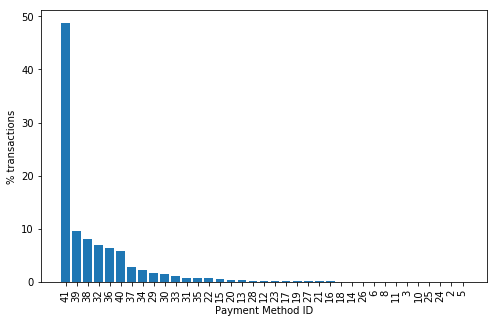

In [28]:
data = trans_df['payment_method_id'].value_counts(1)
labels = list(data.index)
# print(labels)
plt.figure(figsize=(8,5))
plt.bar(np.arange(len(data)), data*100)
plt.xticks(np.arange(len(data)), labels, rotation=90)
plt.xlabel('Payment Method ID')
plt.ylabel('% transactions');

Too many to include all levels of payment_method_id; create column that indicates whether pmi is most common (41) or other

In [75]:
trans_df['payment_method_most_common'] = trans_df['payment_method_id'].apply(lambda x: 1 if x == 41 else 0)

**Other numerical**: check distributions

In [59]:
cols_to_plot = ['payment_plan_days',
       'plan_list_price',
       'actual_amount_paid']

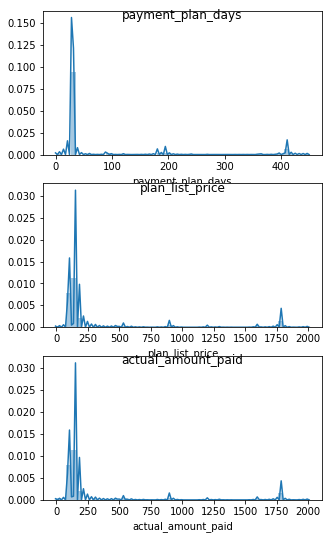

In [61]:
fig, ax = plt.subplots(3,1, figsize=(5,9))
i = 1
for col in cols_to_plot:
    plt.subplot(3,1,i)
    sns.distplot(trans_df[col].dropna())
    plt.title(col, y=0.9)
    i+=1

These look OK

Note: **plan_list_price & actual_amount_paid** are highly correlated, as we'd expect (see graph below). Create a 'plan_actual_diff' column. Keep all for now...

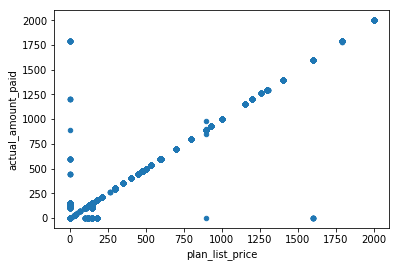

In [85]:
trans_df.plot(x='plan_list_price', y='actual_amount_paid', kind='scatter');

In [71]:
trans_df['plan_actual_diff'] = trans_df['plan_list_price'] - trans_df['actual_amount_paid']

/Users/kendra/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


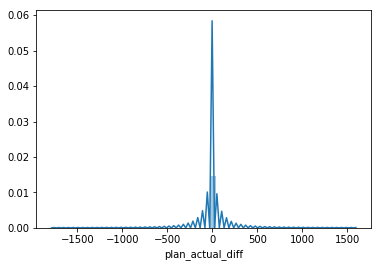

In [72]:
sns.distplot(trans_df['plan_actual_diff'])

### Grouping transactions by user
Explore data of a few users to get idea of how best to aggregate transacation data

In [63]:
def trans_by_user(msno, df):
    return df[df['msno'] == msno]

In [68]:
u1 = trans_by_user('++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=', trans_df)
u1.sort_values(by='transaction_date').head(10)

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
14240,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-01-07,2017-06-12,0
443083,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,119,1,2015-01-09,2017-08-13,0
171355,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-01-09,2017-07-13,0
85921,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-02-07,2017-09-10,0
1244979,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,119,1,2015-02-09,2017-11-05,0
249717,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-02-09,2017-10-08,0
349937,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-03-07,2017-12-06,0
772949,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,119,1,2015-03-09,2018-02-06,0
1137208,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-03-09,2018-01-06,0
515051,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-04-07,2018-03-08,0


Unclear why this user has several transactions in 1 month, for plans that last > 30 days. Presume these are errors in billing, or duplicate charges that were refunded.

*--> Group first by user & month* Get mode for most features.

In [69]:
trans_df['transaction_month'] = pd.PeriodIndex(trans_df['transaction_date'], freq='M')

In [73]:
# create UDF for calculting mode & max absolute value
def agg_mode(x):
    return stats.mode(x)[0][0]

def abs_max(x):
    return max(x, key=abs)

In [95]:
trans_grp_df = trans_df.groupby(['msno','transaction_month']).aggregate({'payment_method_most_common':agg_mode,
                                                               'payment_plan_days': agg_mode,
                                                                'plan_list_price': agg_mode,
                                                               'actual_amount_paid': agg_mode, 
                                                               'is_auto_renew': 'max',
                                                               'is_cancel':'max', 
                                                               'plan_actual_diff': [abs_max, agg_mode]})

In [100]:
trans_grp_df.columns = [fix_col_names(col) for col in trans_grp_df.columns]
trans_grp_df.reset_index(inplace=True)

In [107]:
u1g = trans_by_user('++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=', trans_grp_df)
u1g.head()

,msno,transaction_month,payment_method_most_common_agg_mode,payment_plan_days_agg_mode,plan_list_price_agg_mode,actual_amount_paid_agg_mode,is_auto_renew_max,is_cancel_max,plan_actual_diff_abs_max,plan_actual_diff_agg_mode
232,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,2015-01,1,30,149,149,1,0,30,0
233,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,2015-02,1,30,149,149,1,0,30,0
234,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,2015-03,1,30,149,149,1,0,30,0
235,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,2015-04,1,30,149,149,1,0,30,0
236,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,2015-05,1,0,0,149,1,1,-149,-149


Now our user has a single transaction entry per month.

Group again, this time only by user. Get mode & sum for most features.

In [108]:
# this took a while, so I'm saving the input, so I can profile it later
u.pkl_this('Data/profiler_input.pkl', trans_grp_df)

In [115]:
trans_grp2_df = trans_grp_df.groupby('msno').aggregate({'payment_method_most_common_agg_mode':agg_mode,
                                                'payment_plan_days_agg_mode': [agg_mode,'sum'],
                                                'plan_list_price_agg_mode': [agg_mode, 'sum'],
                                                'actual_amount_paid_agg_mode': [agg_mode, 'sum'],
                                                'is_auto_renew_max': [agg_mode, 'sum'],
                                                'is_cancel_max':[agg_mode, 'sum','count'],
                                                'plan_actual_diff_abs_max':abs_max,
                                                'plan_actual_diff_agg_mode':agg_mode})

In [117]:
trans_grp2_df.reset_index(inplace=True)

trans_grp2_df.columns = ['msno', 'payment_method_most_common_mode', 'payment_plan_days_mode', 
                         'payment_plan_days_sum', 'plan_list_price_mode', 'plan_list_price_sum', 
                         'actual_amount_paid_mode', 'actual_amount_paid_sum',
                         'is_auto_renew_mode', 'is_auto_renew_sum', 'is_cancel_mode','is_cancel_sum', 'trans_count',
                         'plan_actual_diff_abs_max', 'plan_actual_diff_mode']

trans_grp2_df.head()

,msno,payment_method_most_common_mode,payment_plan_days_mode,payment_plan_days_sum,plan_list_price_mode,plan_list_price_sum,actual_amount_paid_mode,actual_amount_paid_sum,is_auto_renew_mode,is_auto_renew_sum,is_cancel_mode,is_cancel_sum,trans_count,plan_actual_diff_abs_max,plan_actual_diff_mode
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,0,395,395,1599,1599,1599,1599,0,0,0,0,1,0,0
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,1,30,30,99,99,99,99,1,1,0,0,1,0,0
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,0,30,60,149,298,149,298,1,2,0,0,2,0,0
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,1,30,30,149,149,149,149,1,1,0,0,1,0,0
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,1,30,30,149,149,149,149,1,1,0,0,1,0,0


Let's check how data aggregation worked for our user:

In [119]:
# expected number of transaction (trans_count)
len(u1g)

13

In [118]:
u1g2 = trans_by_user('++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=', trans_grp2_df)
u1g2

,msno,payment_method_most_common_mode,payment_plan_days_mode,payment_plan_days_sum,plan_list_price_mode,plan_list_price_sum,actual_amount_paid_mode,actual_amount_paid_sum,is_auto_renew_mode,is_auto_renew_sum,is_cancel_mode,is_cancel_sum,trans_count,plan_actual_diff_abs_max,plan_actual_diff_mode
209,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,1,30,360,149,1768,149,1917,1,13,0,1,13,-149,0


Check that aggregations didn't result in any unexpected values:

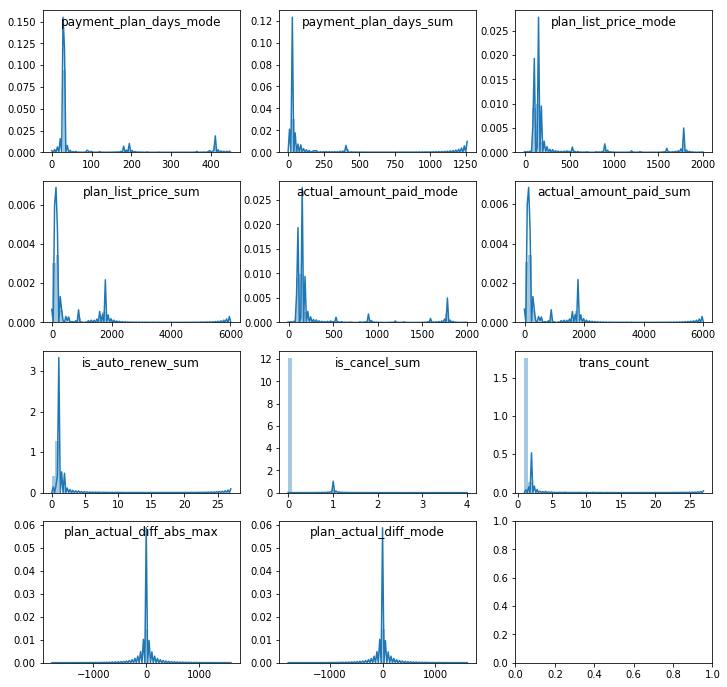

In [130]:
cols_to_plot = ['payment_plan_days_mode', 
                         'payment_plan_days_sum', 'plan_list_price_mode', 'plan_list_price_sum', 
                         'actual_amount_paid_mode', 'actual_amount_paid_sum',
                         'is_auto_renew_sum', 'is_cancel_sum', 'trans_count',
                         'plan_actual_diff_abs_max', 'plan_actual_diff_mode']

n = len(cols_to_plot)
c = n // 4 + 1

fig, ax = plt.subplots(4, c, figsize=(12,12))
i = 1
for col in cols_to_plot:
    plt.subplot(4,c,i)
    sns.distplot(trans_grp2_df[col].dropna())
    plt.xlabel('')
    plt.title(col, y=0.85)
    i+=1

In [131]:
trans_grp2_df['is_cancel_sum'].describe()

count    1.197050e+06
mean     2.896704e-02
std      1.683553e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.000000e+00
Name: is_cancel_sum, dtype: float64

Merge with user_df & save

In [159]:
user_df = pd.merge(user_df, trans_grp2_df, how='left', on='msno')
u.pkl_this('Data/user_df.pkl', user_df)

### A bit more EDA

In [123]:
len(user_df.dropna()) / len(user_df)

0.7474159594627997

An unusual user: a single large transaction

In [125]:
u2 = trans_by_user('+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=', trans_grp2_df)
u2.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,transaction_month,plan_actual_diff,payment_method_most_common
249714,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,22,395,1599,1599,0,2016-10-23,2018-02-06,0,2016-10,0,0


### Test dataset
This data formed the basis for a Kaggle competition. The 'sample_submission' file is supposedly the test data to predict

In [133]:
test_ids = pd.read_csv('Data/sample_submission_v2.csv')

In [139]:
test_ids.head()

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0


In [134]:
len(test_ids), len(churn_df)

(907471, 970960)

A rather large test data set relative to the train (churn_df = train)

In [141]:
test_ids['is_churn'].value_counts(1)

0    1.0
Name: is_churn, dtype: float64

Are they all 0 because we are supposed to assign / predict them? Why not leave them null?

Are users in both test & train datasets?

In [135]:
test_df = pd.merge(user_df, test_ids, on='msno', how='right', suffixes=('_user', '_sub'))

In [141]:
in_both = len(test_df[test_df['is_churn_user'].notna()])
print(in_both, in_both / len(test_df) * 100)

801490 88.32127968827655


In [138]:
# diff = 1 if 'is_churn' doesn't match between test & train
test_df['diff'] = abs(test_df['is_churn_user'] - test_df['is_churn_sub'])

In [139]:
np.sum(test_df['diff']) / len(test_df.dropna())

0.02170730591518368

Notes:
- 2% of churn data doesn't match between train and test.
- 88% of user id's in test data also present in train data. 

Conclusions:
- I'm not sure what to make of the 'sample_submission' data file. 
- I will ignore it, and create a train/test split from the user_df

In [144]:
len(user_df)

970960

In [160]:
# target = 'is_churn'
# y = user_df[target]
# X = user_df.drop(columns=target)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

# u.pkl_this('Data/X_train.pkl', X_train)
# u.pkl_this('Data/X_test.pkl', X_test)
# u.pkl_this('Data/y_train.pkl', y_train)
# u.pkl_this('Data/y_test.pkl', y_test)